In [25]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display
from collections import OrderedDict
from torchinfo import summary


In [26]:
PRED_COLUMN = 'lambda' # mu or lambda

In [27]:
df_train = pd.read_pickle('my_df_train_%s.pickle'%(PRED_COLUMN))
df_test = pd.read_pickle('my_df_test_%s.pickle'%(PRED_COLUMN))
df_train


,lat,lon,year_month,inj_vol,pp,prev_lambda,lambda
0,96.8,36.4,2014.75,"[[1.52072, 0.0, 1.63425, 2.63878, 0.0], [1.908...","[[12.520879999999998, 0.0, 11.397041, 28.64772...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.274851
1,96.8,36.4,2014.83,"[[1.90807, 0.0, 1.85928, 3.16316, 0.0], [1.923...","[[12.520879999999998, 0.0, 11.397041, 28.50983...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.358660
2,96.8,36.4,2014.92,"[[1.92335, 0.0, 1.82606, 3.47917, 0.0], [1.274...","[[12.520879999999998, 0.0, 11.397041, 28.88903...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.358660
3,96.8,36.4,2015.00,"[[1.27496, 0.0, 0.872925, 4.75208, 0.0], [1.07...","[[6.72239, 0.0, -0.172369, 35.120813, 0.0], [5...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.358660
4,96.8,36.4,2015.08,"[[1.07246, 0.0, 0.789056, 4.24828, 0.0], [0.90...","[[5.58475, 0.0, -0.172369, 32.0000334, 0.0], [...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.351548
...,...,...,...,...,...,...,...
57,96.8,35.4,2016.75,"[[2.62944, 0.0, 0.0, 0.0, 1.01359], [2.54863, ...","[[15.7959, 0.0, 0.0, 0.0, 7.901400000000001], ...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100
58,96.8,35.4,2016.83,"[[2.54863, 0.0, 0.0, 0.0, 0.963827], [2.65437,...","[[16.1889, 0.0, 0.0, 0.0, 8.294400000000001], ...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100
59,96.8,35.4,2016.92,"[[2.65437, 0.0, 0.0, 0.0, 1.07463], [2.62847, ...","[[16.48538, 0.0, 0.0, 0.0, 8.59088], [13.83779...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100
60,96.8,35.4,2017.00,"[[2.62847, 0.0, 0.0, 0.0, 1.04501], [2.43947, ...","[[13.83779, 0.0, 0.0, 0.0, 8.59088], [13.62405...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100


In [28]:
for x in df_train.groupby(['lat','lon']):
    print(x[1])
    break

     lat   lon  year_month                                            inj_vol  \
0   96.6  35.6     2012.00  [[0.206679, 0.0, 0.206679, 0.0, 0.0], [0.11376...   
1   96.6  35.6     2012.08  [[0.113768, 0.0, 0.113768, 0.0, 0.0], [0.19276...   
2   96.6  35.6     2012.17  [[0.192769, 0.0, 0.192769, 0.0, 0.0], [0.19855...   
3   96.6  35.6     2012.25  [[0.198553, 0.0, 0.198553, 0.0, 0.0], [0.22677...   
4   96.6  35.6     2012.33  [[0.226778, 0.0, 0.226778, 0.0, 0.0], [0.20887...   
..   ...   ...         ...                                                ...   
59  96.6  35.6     2016.92  [[1.05857, 0.0, 1.07463, 0.0, 0.0], [1.03145, ...   
60  96.6  35.6     2017.00  [[1.03145, 0.0, 1.04501, 0.0, 0.0], [0.964039,...   
61  96.6  35.6     2017.08  [[0.964039, 0.0, 0.965293, 0.0, 0.0], [0.91054...   
62  96.6  35.6     2017.17  [[0.910541, 0.0, 0.911088, 0.0, 0.0], [0.82131...   
63  96.6  35.6     2017.25  [[0.821311, 0.0, 0.821828, 0.0, 0.0], [0.71699...   

                           

In [29]:
for x in df_test.groupby(['lat','lon']):
    print(x[1])
    break

     lat   lon  year_month                                            inj_vol  \
0   96.6  35.6     2017.33  [[0.716998, 0.0, 0.717665, 0.0, 0.0], [0.65129...   
1   96.6  35.6     2017.42  [[0.651291, 0.0, 0.652381, 0.0, 0.0], [0.82427...   
2   96.6  35.6     2017.50  [[0.824271, 0.0, 0.842561, 0.0, 0.0], [0.79525...   
3   96.6  35.6     2017.58  [[0.795251, 0.0, 0.814926, 0.0, 0.0], [0.76603...   
4   96.6  35.6     2017.67  [[0.766037, 0.0, 0.782973, 0.0, 0.0], [0.72489...   
5   96.6  35.6     2017.75  [[0.724893, 0.0, 0.726047, 0.0, 0.0], [0.73737...   
6   96.6  35.6     2017.83  [[0.737372, 0.0, 0.738521, 0.0, 0.0], [0.73129...   
7   96.6  35.6     2017.92  [[0.731299, 0.0, 0.732319, 0.0, 0.0], [0.75154...   
8   96.6  35.6     2018.00  [[0.751546, 0.0, 0.752779, 0.0, 0.0], [0.71358...   
9   96.6  35.6     2018.08  [[0.713581, 0.0, 0.714554, 0.0, 0.0], [0.71031...   
10  96.6  35.6     2018.17  [[0.710311, 0.0, 0.719063, 0.0, 0.0], [0.63506...   
11  96.6  35.6     2018.25  

In [30]:
x = {x[0] for x in df_train.groupby(['lat','lon'])}
len(x)

46

In [31]:
x = {x[0] for x in df_test.groupby(['lat','lon'])}
len(x)

46

In [32]:
# train
inj_vol = np.stack(df_train['inj_vol'].values)
inj_vol = inj_vol.reshape(*inj_vol.shape[:-2], -1)
pp = np.stack(df_train['pp'].values)
pp = pp.reshape(*pp.shape[:-2], -1)
lat = np.stack(df_train['lat'].values)
lat = np.reshape(lat,(-1,1))
lon = np.stack(df_train['lon'].values)
lon = np.reshape(lon,(-1,1))
prev_data = np.stack(df_train['prev_'+PRED_COLUMN].values)
# (2814, 1) (2814, 1) (2814, 12, 1) (2814, 12, 1)
# (2513, 1) (2513, 1) (2513, 12, 5) (2513, 12, 5)
# dim: 2814 x 24
x_train = np.concatenate([lat, lon, inj_vol, pp, prev_data], axis =1)
y_train = df_train[PRED_COLUMN].values

# test
inj_vol = np.stack(df_test['inj_vol'].values)
inj_vol = inj_vol.reshape(*inj_vol.shape[:-2], -1)
pp = np.stack(df_test['pp'].values)
pp = pp.reshape(*pp.shape[:-2], -1)
lat = np.stack(df_test['lat'].values)
lat = np.reshape(lat,(-1,1))
lon = np.stack(df_test['lon'].values)
lon = np.reshape(lon,(-1,1))
prev_data = np.stack(df_test['prev_'+PRED_COLUMN].values)

print(lat.shape,lon.shape,inj_vol.shape,pp.shape)
# dim: _ x 24
x_test = np.concatenate([lat, lon, inj_vol, pp, prev_data], axis =1)
y_test = df_test[PRED_COLUMN].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(729, 1) (729, 1) (729, 60) (729, 60)
(2307, 134) (2307,)
(729, 134) (729,)


In [76]:
import torch 
from torch import nn

class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        # create layers
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout()
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout()
        self.fc3 = nn.Linear(self.hidden_size, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return x

In [77]:
# convert train test data to torch tensors
X_train = torch.from_numpy(x_train.astype('float32'))
Y_train = torch.from_numpy(np.expand_dims(y_train, axis=-1).astype('float32'))
X_test = torch.from_numpy(x_test.astype('float32'))
Y_test = torch.from_numpy(np.expand_dims(y_test, axis=-1).astype('float32'))

In [78]:
print(X_train.shape, Y_train.shape, X_train.dtype, Y_train.dtype)
print(X_test.shape, Y_test.shape, X_test.dtype, Y_test.dtype)


torch.Size([2307, 134]) torch.Size([2307, 1]) torch.float32 torch.float32
torch.Size([729, 134]) torch.Size([729, 1]) torch.float32 torch.float32


In [79]:
# set random seed for initializing model weights
torch.manual_seed(12345)
model = Feedforward(x_train.shape[1], 32)
loss_fn = nn.MSELoss() # +  weight regularization terms
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)


In [80]:
x_train.shape

(2307, 134)

In [81]:
summary(model, input_size=x_train.shape)


Layer (type:depth-idx)                   Output Shape              Param #
Feedforward                              --                        --
├─Linear: 1-1                            [2307, 32]                4,320
├─ReLU: 1-2                              [2307, 32]                --
├─Dropout: 1-3                           [2307, 32]                --
├─Linear: 1-4                            [2307, 32]                1,056
├─ReLU: 1-5                              [2307, 32]                --
├─Dropout: 1-6                           [2307, 32]                --
├─Linear: 1-7                            [2307, 1]                 33
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
Total mult-adds (M): 12.48
Input size (MB): 1.24
Forward/backward pass size (MB): 1.20
Params size (MB): 0.02
Estimated Total Size (MB): 2.46

In [82]:
model.train()
loss_train_array = []
loss_test_array = []
epoch = 3000
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    loss_train = loss_fn(model(X_train), Y_train)
    loss_train_array.append(loss_train.detach().numpy())
    loss_test = loss_fn(model(X_test), Y_test)
    loss_test_array.append(loss_test.detach().numpy())

   
    print('Epoch %s: train loss: %6.4f, test loss %6.4f'%(epoch, loss_train.item(), loss_test.item()))
    # Backward pass
    loss_train.backward()
    optimizer.step()




Epoch 0: train loss: 5.9412, test loss 11.1391
Epoch 1: train loss: 4.2119, test loss 6.7225
Epoch 2: train loss: 3.1077, test loss 5.3651
Epoch 3: train loss: 2.4105, test loss 4.0124
Epoch 4: train loss: 1.9276, test loss 3.0375
Epoch 5: train loss: 1.6232, test loss 3.1067
Epoch 6: train loss: 1.3016, test loss 2.1066
Epoch 7: train loss: 1.0800, test loss 2.0144
Epoch 8: train loss: 0.9312, test loss 1.9095
Epoch 9: train loss: 0.7825, test loss 2.0727
Epoch 10: train loss: 0.7261, test loss 1.3116
Epoch 11: train loss: 0.6447, test loss 1.2028
Epoch 12: train loss: 0.5917, test loss 1.3805
Epoch 13: train loss: 0.5210, test loss 1.0812
Epoch 14: train loss: 0.4915, test loss 0.9037
Epoch 15: train loss: 0.4706, test loss 1.0234
Epoch 16: train loss: 0.4546, test loss 0.9329
Epoch 17: train loss: 0.4166, test loss 0.6256
Epoch 18: train loss: 0.4065, test loss 0.6919
Epoch 19: train loss: 0.3907, test loss 0.7383
Epoch 20: train loss: 0.3791, test loss 0.7266
Epoch 21: train loss: 

Epoch 192: train loss: 0.1522, test loss 0.4602
Epoch 193: train loss: 0.1584, test loss 0.4379
Epoch 194: train loss: 0.1557, test loss 0.3286
Epoch 195: train loss: 0.1540, test loss 0.3558
Epoch 196: train loss: 0.1595, test loss 0.3884
Epoch 197: train loss: 0.1529, test loss 0.4429
Epoch 198: train loss: 0.1560, test loss 0.6216
Epoch 199: train loss: 0.1451, test loss 0.3804
Epoch 200: train loss: 0.1510, test loss 0.5978
Epoch 201: train loss: 0.1516, test loss 0.5916
Epoch 202: train loss: 0.1632, test loss 0.5434
Epoch 203: train loss: 0.1595, test loss 0.2864
Epoch 204: train loss: 0.1532, test loss 0.3761
Epoch 205: train loss: 0.1526, test loss 0.4988
Epoch 206: train loss: 0.1571, test loss 0.4417
Epoch 207: train loss: 0.1480, test loss 0.3733
Epoch 208: train loss: 0.1556, test loss 0.3215
Epoch 209: train loss: 0.1538, test loss 0.2629
Epoch 210: train loss: 0.1552, test loss 0.3241
Epoch 211: train loss: 0.1492, test loss 0.5893
Epoch 212: train loss: 0.1501, test loss

Epoch 385: train loss: 0.1217, test loss 0.4093
Epoch 386: train loss: 0.1326, test loss 0.5044
Epoch 387: train loss: 0.1260, test loss 0.2742
Epoch 388: train loss: 0.1321, test loss 0.3620
Epoch 389: train loss: 0.1168, test loss 0.3189
Epoch 390: train loss: 0.1160, test loss 0.3668
Epoch 391: train loss: 0.1255, test loss 0.1997
Epoch 392: train loss: 0.1166, test loss 0.4582
Epoch 393: train loss: 0.1251, test loss 0.3021
Epoch 394: train loss: 0.1284, test loss 0.3080
Epoch 395: train loss: 0.1171, test loss 0.3753
Epoch 396: train loss: 0.1196, test loss 0.3304
Epoch 397: train loss: 0.1252, test loss 0.4031
Epoch 398: train loss: 0.1267, test loss 0.4844
Epoch 399: train loss: 0.1283, test loss 0.3545
Epoch 400: train loss: 0.1244, test loss 0.3802
Epoch 401: train loss: 0.1201, test loss 0.2482
Epoch 402: train loss: 0.1121, test loss 0.2852
Epoch 403: train loss: 0.1271, test loss 0.4555
Epoch 404: train loss: 0.1258, test loss 0.4886
Epoch 405: train loss: 0.1227, test loss

Epoch 578: train loss: 0.1073, test loss 0.2312
Epoch 579: train loss: 0.1112, test loss 0.3409
Epoch 580: train loss: 0.1008, test loss 0.3576
Epoch 581: train loss: 0.1076, test loss 0.2391
Epoch 582: train loss: 0.1028, test loss 0.2134
Epoch 583: train loss: 0.1105, test loss 0.1997
Epoch 584: train loss: 0.1110, test loss 0.3527
Epoch 585: train loss: 0.1083, test loss 0.3016
Epoch 586: train loss: 0.1142, test loss 0.3236
Epoch 587: train loss: 0.1026, test loss 0.5164
Epoch 588: train loss: 0.1191, test loss 0.4135
Epoch 589: train loss: 0.1055, test loss 0.2758
Epoch 590: train loss: 0.1098, test loss 0.3067
Epoch 591: train loss: 0.0998, test loss 0.2955
Epoch 592: train loss: 0.1102, test loss 0.3622
Epoch 593: train loss: 0.1125, test loss 0.3492
Epoch 594: train loss: 0.1035, test loss 0.2850
Epoch 595: train loss: 0.1052, test loss 0.1492
Epoch 596: train loss: 0.1203, test loss 0.1789
Epoch 597: train loss: 0.1168, test loss 0.2464
Epoch 598: train loss: 0.0995, test loss

Epoch 773: train loss: 0.0886, test loss 0.2919
Epoch 774: train loss: 0.0992, test loss 0.2977
Epoch 775: train loss: 0.0942, test loss 0.2547
Epoch 776: train loss: 0.0944, test loss 0.2943
Epoch 777: train loss: 0.0981, test loss 0.3110
Epoch 778: train loss: 0.0984, test loss 0.2009
Epoch 779: train loss: 0.0979, test loss 0.2204
Epoch 780: train loss: 0.0994, test loss 0.4134
Epoch 781: train loss: 0.1017, test loss 0.2985
Epoch 782: train loss: 0.0971, test loss 0.4605
Epoch 783: train loss: 0.0961, test loss 0.2504
Epoch 784: train loss: 0.0935, test loss 0.3400
Epoch 785: train loss: 0.0943, test loss 0.2454
Epoch 786: train loss: 0.1007, test loss 0.2631
Epoch 787: train loss: 0.0933, test loss 0.2706
Epoch 788: train loss: 0.0900, test loss 0.1473
Epoch 789: train loss: 0.1028, test loss 0.2649
Epoch 790: train loss: 0.0915, test loss 0.3430
Epoch 791: train loss: 0.0949, test loss 0.3295
Epoch 792: train loss: 0.0971, test loss 0.3945
Epoch 793: train loss: 0.0903, test loss

Epoch 964: train loss: 0.0847, test loss 0.2891
Epoch 965: train loss: 0.0823, test loss 0.3466
Epoch 966: train loss: 0.0881, test loss 0.4218
Epoch 967: train loss: 0.0831, test loss 0.3779
Epoch 968: train loss: 0.0870, test loss 0.2233
Epoch 969: train loss: 0.0925, test loss 0.2140
Epoch 970: train loss: 0.0884, test loss 0.2395
Epoch 971: train loss: 0.0932, test loss 0.2969
Epoch 972: train loss: 0.0824, test loss 0.1999
Epoch 973: train loss: 0.0912, test loss 0.3435
Epoch 974: train loss: 0.0877, test loss 0.3481
Epoch 975: train loss: 0.0825, test loss 0.1710
Epoch 976: train loss: 0.0948, test loss 0.1741
Epoch 977: train loss: 0.0918, test loss 0.2367
Epoch 978: train loss: 0.0842, test loss 0.2827
Epoch 979: train loss: 0.0890, test loss 0.2342
Epoch 980: train loss: 0.0885, test loss 0.3260
Epoch 981: train loss: 0.0907, test loss 0.2560
Epoch 982: train loss: 0.0843, test loss 0.2772
Epoch 983: train loss: 0.0864, test loss 0.2299
Epoch 984: train loss: 0.0832, test loss

Epoch 1142: train loss: 0.0832, test loss 0.2019
Epoch 1143: train loss: 0.0815, test loss 0.2819
Epoch 1144: train loss: 0.0870, test loss 0.2090
Epoch 1145: train loss: 0.0810, test loss 0.1936
Epoch 1146: train loss: 0.0835, test loss 0.2686
Epoch 1147: train loss: 0.0821, test loss 0.2108
Epoch 1148: train loss: 0.0873, test loss 0.3041
Epoch 1149: train loss: 0.0826, test loss 0.4589
Epoch 1150: train loss: 0.0837, test loss 0.1990
Epoch 1151: train loss: 0.0828, test loss 0.3407
Epoch 1152: train loss: 0.0812, test loss 0.2414
Epoch 1153: train loss: 0.0756, test loss 0.2324
Epoch 1154: train loss: 0.0838, test loss 0.2113
Epoch 1155: train loss: 0.0801, test loss 0.2386
Epoch 1156: train loss: 0.0823, test loss 0.2437
Epoch 1157: train loss: 0.0823, test loss 0.3314
Epoch 1158: train loss: 0.0847, test loss 0.2983
Epoch 1159: train loss: 0.0829, test loss 0.3333
Epoch 1160: train loss: 0.0749, test loss 0.3429
Epoch 1161: train loss: 0.0842, test loss 0.2502
Epoch 1162: train lo

Epoch 1318: train loss: 0.0752, test loss 0.2777
Epoch 1319: train loss: 0.0764, test loss 0.4257
Epoch 1320: train loss: 0.0741, test loss 0.3752
Epoch 1321: train loss: 0.0779, test loss 0.1978
Epoch 1322: train loss: 0.0751, test loss 0.3304
Epoch 1323: train loss: 0.0721, test loss 0.2598
Epoch 1324: train loss: 0.0815, test loss 0.2893
Epoch 1325: train loss: 0.0699, test loss 0.2409
Epoch 1326: train loss: 0.0800, test loss 0.1947
Epoch 1327: train loss: 0.0704, test loss 0.2457
Epoch 1328: train loss: 0.0712, test loss 0.3692
Epoch 1329: train loss: 0.0734, test loss 0.2784
Epoch 1330: train loss: 0.0803, test loss 0.3426
Epoch 1331: train loss: 0.0767, test loss 0.2778
Epoch 1332: train loss: 0.0784, test loss 0.2509
Epoch 1333: train loss: 0.0741, test loss 0.4595
Epoch 1334: train loss: 0.0737, test loss 0.2425
Epoch 1335: train loss: 0.0751, test loss 0.1620
Epoch 1336: train loss: 0.0814, test loss 0.3301
Epoch 1337: train loss: 0.0715, test loss 0.1639
Epoch 1338: train lo

Epoch 1511: train loss: 0.0761, test loss 0.3262
Epoch 1512: train loss: 0.0652, test loss 0.3264
Epoch 1513: train loss: 0.0683, test loss 0.1653
Epoch 1514: train loss: 0.0686, test loss 0.2313
Epoch 1515: train loss: 0.0688, test loss 0.1866
Epoch 1516: train loss: 0.0689, test loss 0.1945
Epoch 1517: train loss: 0.0699, test loss 0.2715
Epoch 1518: train loss: 0.0746, test loss 0.3305
Epoch 1519: train loss: 0.0726, test loss 0.2466
Epoch 1520: train loss: 0.0756, test loss 0.2919
Epoch 1521: train loss: 0.0683, test loss 0.2858
Epoch 1522: train loss: 0.0685, test loss 0.4635
Epoch 1523: train loss: 0.0645, test loss 0.2268
Epoch 1524: train loss: 0.0692, test loss 0.1439
Epoch 1525: train loss: 0.0726, test loss 0.1831
Epoch 1526: train loss: 0.0689, test loss 0.2504
Epoch 1527: train loss: 0.0727, test loss 0.2582
Epoch 1528: train loss: 0.0687, test loss 0.2991
Epoch 1529: train loss: 0.0740, test loss 0.2956
Epoch 1530: train loss: 0.0631, test loss 0.2190
Epoch 1531: train lo

Epoch 1704: train loss: 0.0646, test loss 0.4026
Epoch 1705: train loss: 0.0650, test loss 0.1854
Epoch 1706: train loss: 0.0599, test loss 0.3129
Epoch 1707: train loss: 0.0720, test loss 0.3858
Epoch 1708: train loss: 0.0655, test loss 0.3716
Epoch 1709: train loss: 0.0637, test loss 0.3919
Epoch 1710: train loss: 0.0665, test loss 0.3090
Epoch 1711: train loss: 0.0679, test loss 0.2216
Epoch 1712: train loss: 0.0611, test loss 0.2472
Epoch 1713: train loss: 0.0700, test loss 0.2837
Epoch 1714: train loss: 0.0671, test loss 0.4094
Epoch 1715: train loss: 0.0668, test loss 0.4253
Epoch 1716: train loss: 0.0736, test loss 0.3274
Epoch 1717: train loss: 0.0653, test loss 0.3422
Epoch 1718: train loss: 0.0639, test loss 0.1697
Epoch 1719: train loss: 0.0683, test loss 0.1643
Epoch 1720: train loss: 0.0653, test loss 0.3032
Epoch 1721: train loss: 0.0654, test loss 0.3778
Epoch 1722: train loss: 0.0609, test loss 0.1836
Epoch 1723: train loss: 0.0682, test loss 0.3071
Epoch 1724: train lo

Epoch 1896: train loss: 0.0606, test loss 0.4000
Epoch 1897: train loss: 0.0610, test loss 0.4097
Epoch 1898: train loss: 0.0588, test loss 0.1920
Epoch 1899: train loss: 0.0639, test loss 0.5276
Epoch 1900: train loss: 0.0597, test loss 0.1398
Epoch 1901: train loss: 0.0610, test loss 0.4010
Epoch 1902: train loss: 0.0639, test loss 0.1769
Epoch 1903: train loss: 0.0662, test loss 0.3150
Epoch 1904: train loss: 0.0594, test loss 0.1839
Epoch 1905: train loss: 0.0596, test loss 0.3197
Epoch 1906: train loss: 0.0620, test loss 0.2395
Epoch 1907: train loss: 0.0692, test loss 0.2047
Epoch 1908: train loss: 0.0623, test loss 0.3205
Epoch 1909: train loss: 0.0554, test loss 0.4757
Epoch 1910: train loss: 0.0586, test loss 0.2801
Epoch 1911: train loss: 0.0592, test loss 0.3631
Epoch 1912: train loss: 0.0688, test loss 0.2928
Epoch 1913: train loss: 0.0551, test loss 0.2844
Epoch 1914: train loss: 0.0620, test loss 0.2126
Epoch 1915: train loss: 0.0692, test loss 0.2256
Epoch 1916: train lo

Epoch 2089: train loss: 0.0591, test loss 0.3005
Epoch 2090: train loss: 0.0624, test loss 0.2484
Epoch 2091: train loss: 0.0591, test loss 0.2470
Epoch 2092: train loss: 0.0561, test loss 0.1933
Epoch 2093: train loss: 0.0645, test loss 0.5985
Epoch 2094: train loss: 0.0573, test loss 0.3727
Epoch 2095: train loss: 0.0536, test loss 0.3168
Epoch 2096: train loss: 0.0589, test loss 0.2812
Epoch 2097: train loss: 0.0571, test loss 0.3549
Epoch 2098: train loss: 0.0571, test loss 0.2142
Epoch 2099: train loss: 0.0550, test loss 0.2194
Epoch 2100: train loss: 0.0604, test loss 0.3134
Epoch 2101: train loss: 0.0644, test loss 0.3916
Epoch 2102: train loss: 0.0609, test loss 0.2301
Epoch 2103: train loss: 0.0644, test loss 0.2531
Epoch 2104: train loss: 0.0622, test loss 0.3071
Epoch 2105: train loss: 0.0631, test loss 0.3350
Epoch 2106: train loss: 0.0585, test loss 0.1991
Epoch 2107: train loss: 0.0632, test loss 0.4025
Epoch 2108: train loss: 0.0569, test loss 0.3474
Epoch 2109: train lo

Epoch 2282: train loss: 0.0636, test loss 0.3216
Epoch 2283: train loss: 0.0582, test loss 0.2195
Epoch 2284: train loss: 0.0608, test loss 0.2978
Epoch 2285: train loss: 0.0555, test loss 0.2037
Epoch 2286: train loss: 0.0625, test loss 0.2737
Epoch 2287: train loss: 0.0575, test loss 0.2283
Epoch 2288: train loss: 0.0552, test loss 0.2711
Epoch 2289: train loss: 0.0578, test loss 0.2291
Epoch 2290: train loss: 0.0565, test loss 0.3759
Epoch 2291: train loss: 0.0589, test loss 0.2493
Epoch 2292: train loss: 0.0590, test loss 0.2599
Epoch 2293: train loss: 0.0602, test loss 0.2302
Epoch 2294: train loss: 0.0607, test loss 0.5181
Epoch 2295: train loss: 0.0532, test loss 0.2395
Epoch 2296: train loss: 0.0548, test loss 0.4258
Epoch 2297: train loss: 0.0557, test loss 0.2274
Epoch 2298: train loss: 0.0581, test loss 0.3902
Epoch 2299: train loss: 0.0617, test loss 0.3127
Epoch 2300: train loss: 0.0573, test loss 0.3923
Epoch 2301: train loss: 0.0558, test loss 0.2944
Epoch 2302: train lo

Epoch 2475: train loss: 0.0535, test loss 0.2130
Epoch 2476: train loss: 0.0578, test loss 0.2614
Epoch 2477: train loss: 0.0552, test loss 0.2326
Epoch 2478: train loss: 0.0546, test loss 0.2356
Epoch 2479: train loss: 0.0552, test loss 0.2490
Epoch 2480: train loss: 0.0505, test loss 0.2107
Epoch 2481: train loss: 0.0493, test loss 0.3243
Epoch 2482: train loss: 0.0521, test loss 0.3720
Epoch 2483: train loss: 0.0558, test loss 0.2465
Epoch 2484: train loss: 0.0521, test loss 0.2374
Epoch 2485: train loss: 0.0524, test loss 0.2065
Epoch 2486: train loss: 0.0544, test loss 0.2511
Epoch 2487: train loss: 0.0534, test loss 0.2909
Epoch 2488: train loss: 0.0551, test loss 0.2577
Epoch 2489: train loss: 0.0503, test loss 0.4142
Epoch 2490: train loss: 0.0533, test loss 0.2628
Epoch 2491: train loss: 0.0561, test loss 0.3189
Epoch 2492: train loss: 0.0558, test loss 0.1657
Epoch 2493: train loss: 0.0531, test loss 0.2189
Epoch 2494: train loss: 0.0530, test loss 0.2312
Epoch 2495: train lo

Epoch 2666: train loss: 0.0526, test loss 0.2103
Epoch 2667: train loss: 0.0523, test loss 0.3402
Epoch 2668: train loss: 0.0485, test loss 0.1406
Epoch 2669: train loss: 0.0508, test loss 0.2880
Epoch 2670: train loss: 0.0531, test loss 0.4511
Epoch 2671: train loss: 0.0482, test loss 0.3927
Epoch 2672: train loss: 0.0494, test loss 0.2113
Epoch 2673: train loss: 0.0539, test loss 0.1669
Epoch 2674: train loss: 0.0568, test loss 0.2910
Epoch 2675: train loss: 0.0550, test loss 0.2624
Epoch 2676: train loss: 0.0523, test loss 0.2860
Epoch 2677: train loss: 0.0495, test loss 0.1990
Epoch 2678: train loss: 0.0541, test loss 0.2234
Epoch 2679: train loss: 0.0497, test loss 0.2032
Epoch 2680: train loss: 0.0505, test loss 0.2746
Epoch 2681: train loss: 0.0534, test loss 0.3078
Epoch 2682: train loss: 0.0485, test loss 0.3221
Epoch 2683: train loss: 0.0480, test loss 0.1985
Epoch 2684: train loss: 0.0504, test loss 0.2460
Epoch 2685: train loss: 0.0520, test loss 0.1434
Epoch 2686: train lo

Epoch 2859: train loss: 0.0476, test loss 0.2864
Epoch 2860: train loss: 0.0520, test loss 0.2357
Epoch 2861: train loss: 0.0499, test loss 0.2520
Epoch 2862: train loss: 0.0507, test loss 0.3706
Epoch 2863: train loss: 0.0511, test loss 0.3245
Epoch 2864: train loss: 0.0534, test loss 0.3027
Epoch 2865: train loss: 0.0490, test loss 0.3035
Epoch 2866: train loss: 0.0507, test loss 0.2766
Epoch 2867: train loss: 0.0512, test loss 0.5951
Epoch 2868: train loss: 0.0540, test loss 0.4193
Epoch 2869: train loss: 0.0448, test loss 0.3980
Epoch 2870: train loss: 0.0497, test loss 0.5418
Epoch 2871: train loss: 0.0495, test loss 0.3499
Epoch 2872: train loss: 0.0509, test loss 0.2190
Epoch 2873: train loss: 0.0465, test loss 0.3332
Epoch 2874: train loss: 0.0554, test loss 0.2706
Epoch 2875: train loss: 0.0495, test loss 0.2633
Epoch 2876: train loss: 0.0465, test loss 0.2605
Epoch 2877: train loss: 0.0457, test loss 0.3130
Epoch 2878: train loss: 0.0505, test loss 0.2956
Epoch 2879: train lo

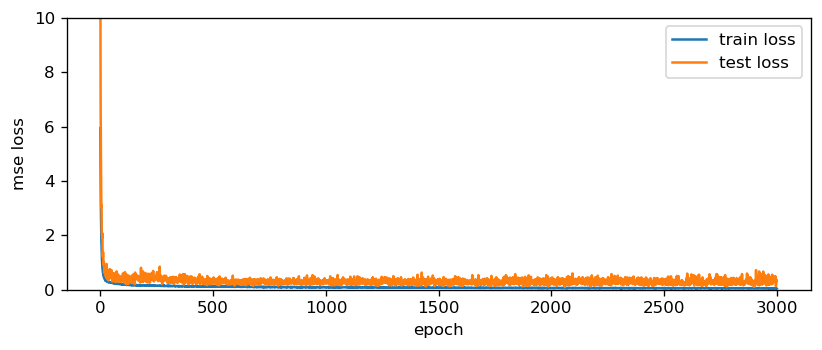

In [83]:
plt.figure(figsize=(8,3), dpi=120)
plt.plot(loss_train_array)
plt.plot(loss_test_array)
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.ylim([0,10])
plt.show()

In [84]:
loss_train_array[-1], loss_test_array[-1]

(array(0.04281748, dtype=float32), array(0.33305275, dtype=float32))

# Training and testing for each cordinate

In [85]:
model.eval()
df_test['Pred'] = model(X_test).detach().numpy()
df_train['Pred'] = model(X_train).detach().numpy()



In [86]:
df_train.head()

,lat,lon,year_month,inj_vol,pp,prev_lambda,lambda,Pred
0,96.8,36.4,2014.75,"[[1.52072, 0.0, 1.63425, 2.63878, 0.0], [1.908...","[[12.520879999999998, 0.0, 11.397041, 28.64772...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.274851,0.319975
1,96.8,36.4,2014.83,"[[1.90807, 0.0, 1.85928, 3.16316, 0.0], [1.923...","[[12.520879999999998, 0.0, 11.397041, 28.50983...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.358660,0.320095
2,96.8,36.4,2014.92,"[[1.92335, 0.0, 1.82606, 3.47917, 0.0], [1.274...","[[12.520879999999998, 0.0, 11.397041, 28.88903...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.358660,0.324468
3,96.8,36.4,2015.00,"[[1.27496, 0.0, 0.872925, 4.75208, 0.0], [1.07...","[[6.72239, 0.0, -0.172369, 35.120813, 0.0], [5...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.358660,0.347695
4,96.8,36.4,2015.08,"[[1.07246, 0.0, 0.789056, 4.24828, 0.0], [0.90...","[[5.58475, 0.0, -0.172369, 32.0000334, 0.0], [...","[0.2748506186887427, 0.2748506186887427, 0.274...",0.351548,0.359770


In [87]:

loss_co_ord = OrderedDict()
for co_ord, df_c in df_test.groupby(['lat','lon']):
    loss = (df_c['Pred'] - df_c[PRED_COLUMN])**2
    loss_co_ord[str(co_ord)] = loss
    # loss_co_ord.append(loss.detach().item())

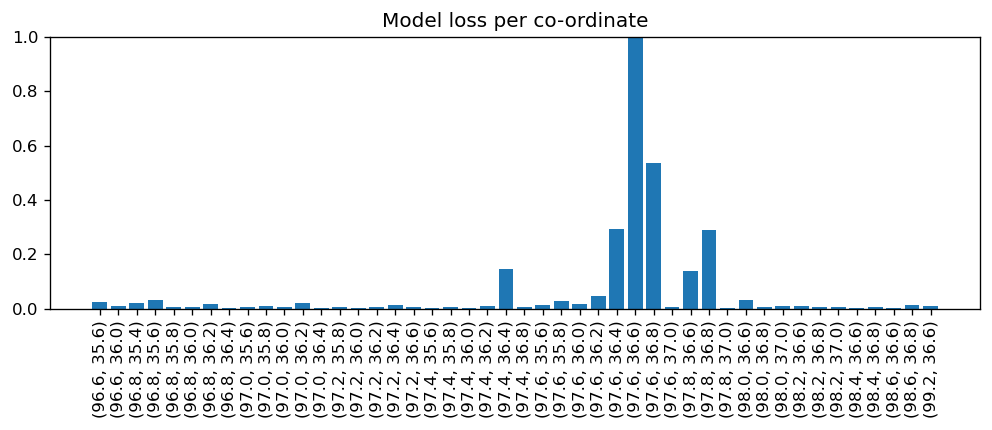

In [88]:
plt.figure(figsize=(10,3), dpi=120)
plt.bar(loss_co_ord.keys(), [x.mean() for x in loss_co_ord.values()])
# notch shape box plot
# plt.boxplot(loss_co_ord.values(),
#                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=loss_co_ord.keys())  # will be used to label x-ticks
plt.ylim([0,1])
plt.xticks(rotation=90)
plt.title('Model loss per co-ordinate')
plt.show()

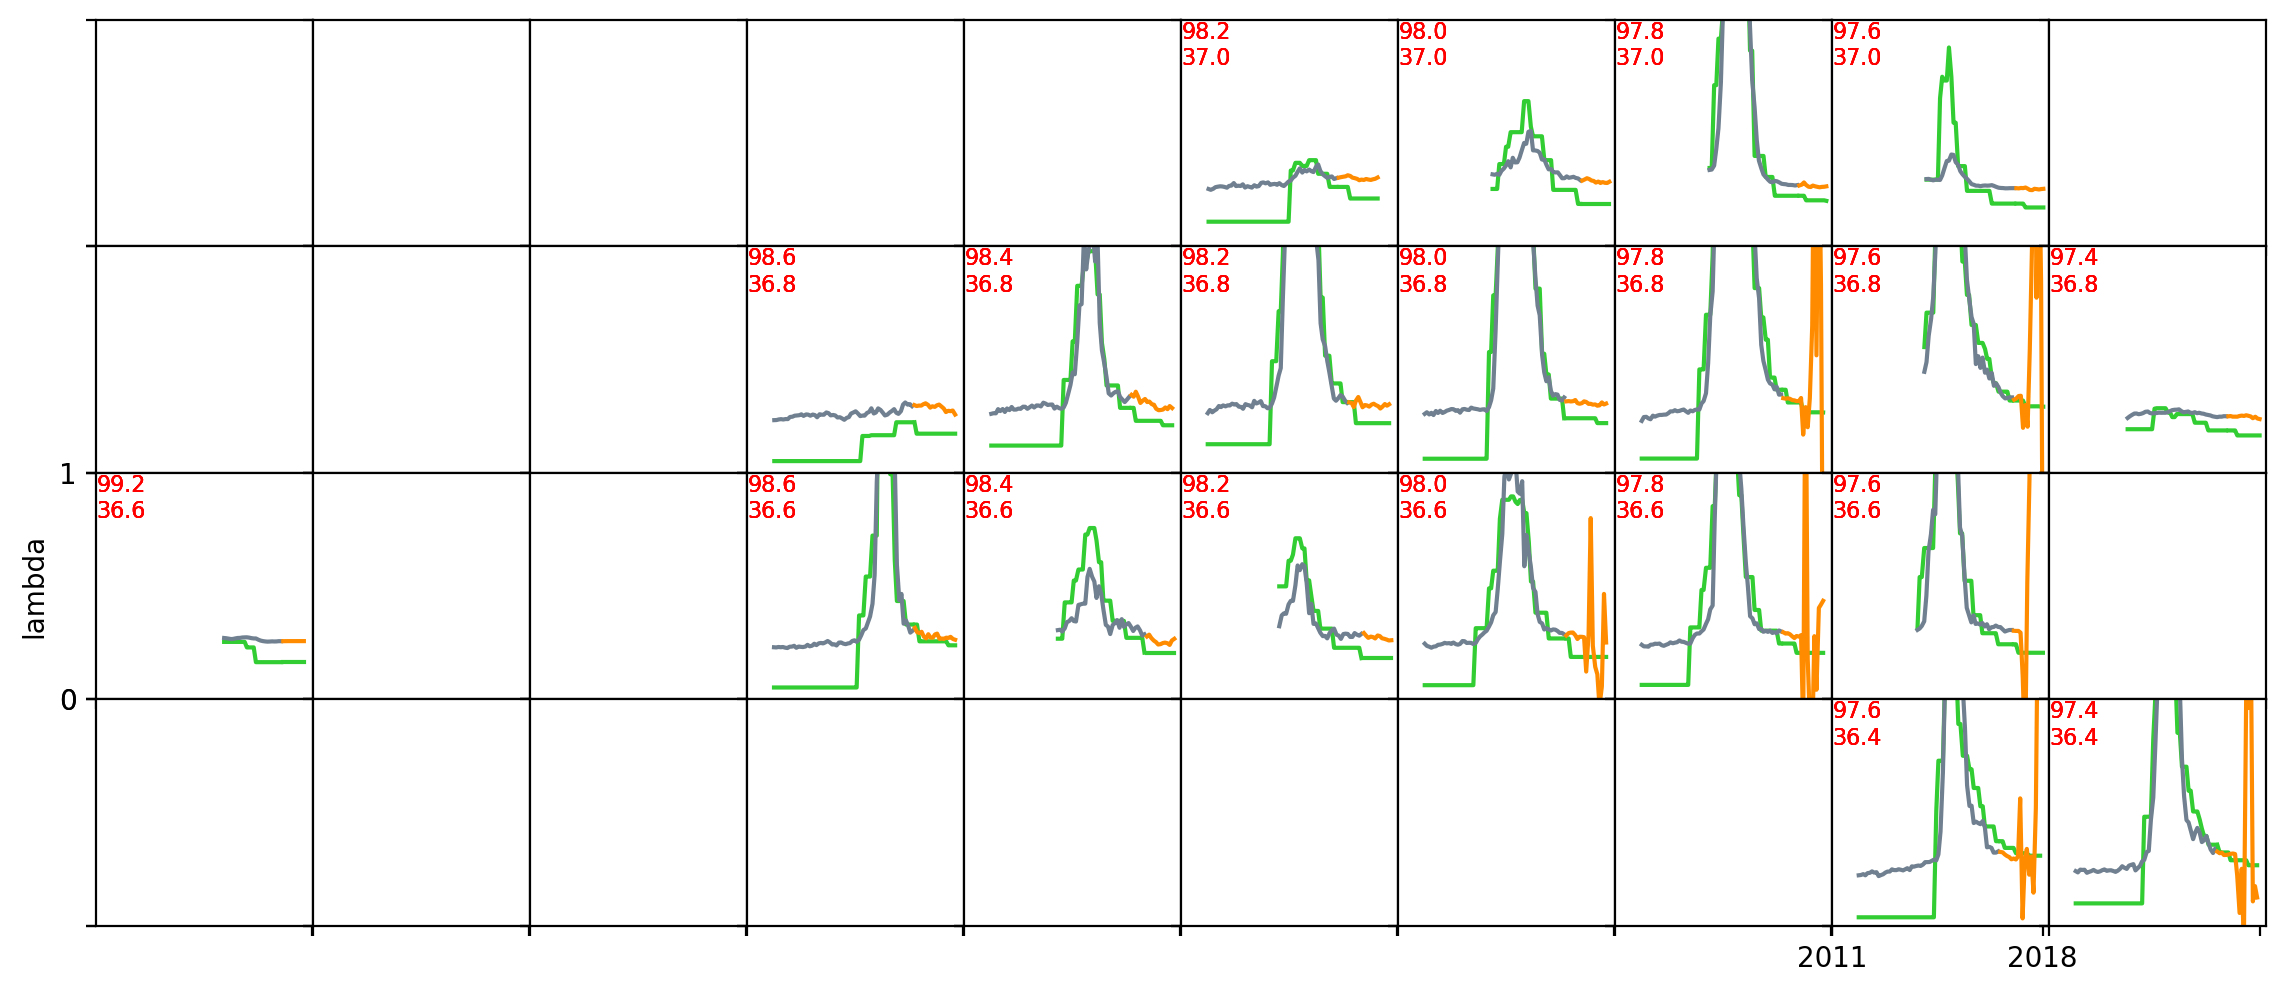

In [89]:
fig, axes = plt.subplots(4, 10, sharex=False, sharey=False, figsize=(14,6), dpi=200)
axes = axes.ravel()



def plot_pred(axes, df_pred, column, color):
    max_data = 1
    df_pred = df_pred.groupby(['lat','lon'])
    
    ax_idx = 0
    init=False
    for lon in np.arange(37.0, 36.2, -0.2):
        for lat in np.arange(99.2, 97.2, -0.2):
            ax = axes[ax_idx]
            lat_s = "%3.1f"%(lat)
            lon_s = "%3.1f"%(lon)
            # get df for given lat lon
            try:
                df = df_pred.get_group((round(lat,1),round(lon,1)))
                ax.plot(df.year_month,df[column], color)
                ax.text(2011.00, max_data - 0.2, '%s\n%s'%(lat_s, lon_s), fontsize=8, color='r')
            except KeyError as e:
                pass
                # print('Key error %s'%(e))

            # set injection volume limit
            ax.set_ylim([0, max_data])
            yticks = np.linspace(0, max_data, 3).astype('int')
            ax.set_yticks(yticks)
            ax.set_xticks([2011.00, 2018.92])
            
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            # injection volume y axis label
            if lat_s == "99.2" and lon_s == "36.6":
                ax.set_yticklabels(yticks, color='k')
                ax.set_ylabel(PRED_COLUMN, color='k')

            if lat_s == "97.6" and lon_s == "36.4":
                ax.set_xticklabels([2011, 2018])
            
            ax_idx += 1

plot_pred(axes, df_train, PRED_COLUMN, 'limegreen')
plot_pred(axes, df_train, 'Pred', 'slategrey')

plot_pred(axes, df_test, PRED_COLUMN, 'limegreen')
plot_pred(axes, df_test, 'Pred', 'darkorange')





# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()